# Tabulation API Example: Presumed PDF SLFM Tables

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_
- Building presumed PDF adiabatic and nonadiabatic SFLM libraries for turbulent flows
- Using Spitfire's wrapper around the Python interface of [`TabProps`](https://multiscale.utah.edu/software/) to easily extend tables with clipped Gaussian and Beta PDFs

Tabulated chemistry models can often be split into two pieces: a _reaction_ model and a _mixing_ model. The reaction model describes small scale laminar flame structure, for instance equilibrium (fast chemistry) or diffusion-reaction (SLFM), possibly perturbed by radiative heat losses. A mixing model is unnecessary in a CFD simulation when the flow is laminar or when all scales of turbulence are resolved as in direct numerical simulation (DNS). In Reynolds-averaged Navier-Stokes (RANS) or large eddy simulation (LES), however, small scales are modeled instead of being resolved by the mesh. Here a mixing model is necessary to account for turbulence-chemistry interaction on subgrid scales.

In RANS and LES, typically two statistical moments of conserved scalars are transported on the mesh and the mixing model accounts for unresolved, or subgrid, heterogeneity. A mixing model accomplishes this by describing the statistical distribution of the subgrid scalar field. Spitfire and the [Python interface of the `TabProps` code](https://multiscale.utah.edu/software/) can be combined to build reaction models and then incorporate presumed PDF mixing models.


## The Reaction Models
First we'll build the reaction models for an n-heptane/air system following prior demonstrations.

In [1]:
from spitfire import (ChemicalMechanismSpec, 
                      Library,
                      FlameletSpec, 
                      build_adiabatic_slfm_library,
                      build_nonadiabatic_defect_transient_slfm_library)
import matplotlib.pyplot as plt
import numpy as np

mech = ChemicalMechanismSpec(cantera_xml='heptane-liu-hewson-chen-pitsch-highT.xml', 
                             group_name='gas')

pressure = 101325.

air = mech.stream(stp_air=True)
fuel = mech.stream('TPY', (372., pressure, 'NXC7H16:1'))

flamelet_specs = FlameletSpec(mech_spec=mech, 
                              initial_condition='equilibrium',
                              oxy_stream=air,
                              fuel_stream=fuel,
                              grid_points=34)

l_ad = build_adiabatic_slfm_library(flamelet_specs,
                                    diss_rate_values=np.logspace(-1, 2, 8),
                                    diss_rate_ref='stoichiometric',
                                    verbose=False)

l_na = build_nonadiabatic_defect_transient_slfm_library(flamelet_specs,
                                                        diss_rate_values=np.logspace(-1, 2, 8),
                                                        diss_rate_ref='stoichiometric',
                                                        n_defect_st=16,
                                                        integration_args={'transient_tolerance': 1.e-12})
# note here: the transient_tolerance is specified to avoid seeing "failure" messages,
# but in absence of this flag, Spitfire will automatically iterate after failures to obtain a solution

----------------------------------------------------------------------------------
building nonadiabatic (defect) SLFM library
----------------------------------------------------------------------------------
- mechanism: heptane-liu-hewson-chen-pitsch-highT.xml
- 38 species, 105 reactions
- stoichiometric mixture fraction: 0.062
----------------------------------------------------------------------------------
----------------------------------------------------------------------------------
building adiabatic SLFM library
----------------------------------------------------------------------------------
- mechanism: heptane-liu-hewson-chen-pitsch-highT.xml
- 38 species, 105 reactions
- stoichiometric mixture fraction: 0.062
----------------------------------------------------------------------------------
   1/   8 (chi_stoich =  1.0e-01 1/s)  converged in   0.66 s, T_max = 2122.1
   2/   8 (chi_stoich =  2.7e-01 1/s)  converged in   0.01 s, T_max = 2089.8
   3/   8 (chi_stoich =  7

## Tabulated Properties

Running a CFD calculation requires fluid properties such as the viscosity, heat capacity, and enthalpy. These are computed on the laminar reaction model and are then integrated with the presumed PDF. So before applying the presumed PDF mixing model we make new libraries with just a few properties likely necessary for the simulation. 
We typically don't need to tabulate the entire set of mass fractions, so we'll remove them to save time.

In [2]:
from spitfire import get_ct_solution_array
import copy

def tabulate_properties(TY_lib):
    ct_sol, lib_shape = get_ct_solution_array(mech, TY_lib)
    prop_lib = copy.copy(TY_lib)
    prop_lib.remove(*prop_lib.props)
    
    prop_lib['temperature'] = ct_sol.T.reshape(lib_shape)
    prop_lib['viscosity'] = ct_sol.viscosity.reshape(lib_shape)
    prop_lib['enthalpy'] = ct_sol.enthalpy_mass.reshape(lib_shape)
    prop_lib['heat_capacity_cp'] = ct_sol.cp_mass.reshape(lib_shape)

    return prop_lib


prop_ad = tabulate_properties(l_ad)
prop_na = tabulate_properties(l_na)

## Presumed PDFs

First, we'll use TabProps to evaluate the clipped Gaussian and $\beta$ PDFs for some represenative means and variances. Note the major differences between the PDF types at higher variances and near the boundaries. The poor behavior of the $\beta$ PDF in these regimes makes it substantially harder to integrate than the clipped Gaussian.

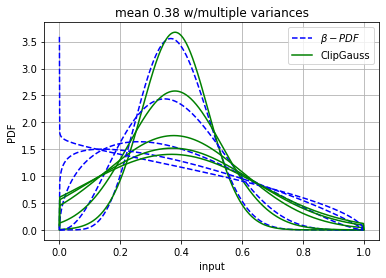

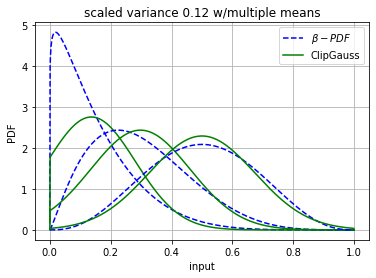

In [3]:
from pytabprops import ClippedGaussMixMdl, BetaMixMdl

ztest = np.linspace(0, 1, 1000)

cg = ClippedGaussMixMdl(201, 201, False)
bp = BetaMixMdl()

zmean = 0.38
for i, zsvar in enumerate([0.05, 0.1, 0.2, 0.25, 0.28]):
    bp.set_mean(zmean)
    bp.set_scaled_variance(zsvar)
    plt.plot(ztest, bp.get_pdf(ztest), 'b--', label='$\\beta-PDF$' if i == 0 else None)
    cg.set_mean(zmean)
    cg.set_scaled_variance(zsvar)
    plt.plot(ztest, cg.get_pdf(ztest), 'g-', label='ClipGauss' if i == 0 else None)
plt.title(f'mean {zmean:.2f} w/multiple variances')
plt.xlabel('input')
plt.ylabel('PDF')
plt.grid()
plt.legend()
plt.show()

zsvar = 0.12
for i, zmean in enumerate([0.15, 0.3, 0.5]):
    bp.set_mean(zmean)
    bp.set_scaled_variance(zsvar)
    plt.plot(ztest, bp.get_pdf(ztest), 'b--', label='$\\beta-PDF$' if i == 0 else None)
    cg.set_mean(zmean)
    cg.set_scaled_variance(zsvar)
    plt.plot(ztest, cg.get_pdf(ztest), 'g-', label='ClipGauss' if i == 0 else None)
plt.title(f'scaled variance {zsvar:.2f} w/multiple means')
plt.xlabel('input')
plt.ylabel('PDF')
plt.grid()
plt.legend()
plt.show()

## Incorporating the Mixing Model: Clipped Gaussian and $\beta$ PDFs

Spitfire provides the `apply_mixing_model` which takes an existing `Library`, for instance those computed above, and incorporates subgrid variation for all dimensions and adds the (default) suffix `_mean`.

Spitfire provides two optimized PDF integrators from TabProps, the clipped Gaussian (`'ClipGauss'`) and the beta PDF (`'Beta'`). These PDFs and their integrals are challenging to implement and TabProps' implementation is excellent. In addition these, Spitfire allows you to "roll your own" PDF integrator, a feature to be shown in following demonstrations.

In [4]:
from spitfire import apply_mixing_model, PDFSpec

scaled_variance_values = np.array([0, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])

mixing_spec = {'mixture_fraction': PDFSpec(pdf='ClipGauss', scaled_variance_values=scaled_variance_values)}

t_cg_prop_ad = apply_mixing_model(prop_ad, mixing_spec, verbose=True)
t_cg_prop_na = apply_mixing_model(prop_na, mixing_spec, verbose=True)

scaled_scalar_variance_mean: computing 10880 integrals... completed in 1.7 seconds, average = 6231 integrals/s.
scaled_scalar_variance_mean: computing 174080 integrals... completed in 26.3 seconds, average = 6609 integrals/s.


Now take a quick look at the tables. Input dimensions have been suffixed with `_mean` and the scalar variance (its scaled form that varies between 0 and 1) is incorporated as the final dimension. Futher, the `extra_attributes` dictionary that holds library metadata saves the `mixing_spec` dictionary for later reference.

In [5]:
print(t_cg_prop_ad)
print(t_cg_prop_na)


Spitfire Library with 3 dimensions and 4 properties
------------------------------------------
1. Dimension "mixture_fraction_mean" spanning [0.0, 1.0] with 34 points
2. Dimension "dissipation_rate_stoich_mean" spanning [0.1, 100.0] with 8 points
3. Dimension "scaled_scalar_variance_mean" spanning [0.0, 1.0] with 10 points
------------------------------------------
temperature         , min = 300.0 max = 2122.0969552261395
viscosity           , min = 1.2370131775920866e-05 max = 6.906467776682997e-05
enthalpy            , min = -1739935.6849118916 max = 1901.8191601112546
heat_capacity_cp    , min = 1011.3329912202539 max = 2422.2079033534937
Extra attributes: {'mech_spec': <spitfire.chemistry.mechanism.ChemicalMechanismSpec object at 0x7fb4465fe050>, 'mixing_spec': {'mixture_fraction': <spitfire.chemistry.tabulation.PDFSpec object at 0x7fb459b7a350>, 'dissipation_rate_stoich': <spitfire.chemistry.tabulation.PDFSpec object at 0x7fb459b7a2d0>}}
-----------------------------------------

In [6]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import Normalize

To finish things off we can show some simple visualiations of the data.

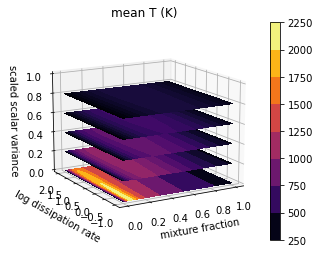

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
z = np.squeeze(t_cg_prop_ad.mixture_fraction_mean_grid[:, :, 0])
x = np.squeeze(np.log10(t_cg_prop_ad.dissipation_rate_stoich_mean_grid[:, :, 0]))
v_list = t_cg_prop_ad.scaled_scalar_variance_mean_values
for idx in [7, 6, 5, 4, 0]:
    p = ax.contourf(z, x, np.squeeze(t_cg_prop_ad['temperature'][:, :, idx]), 
                    offset=v_list[idx], 
                    cmap='inferno',
                    norm=Normalize(300, 2200))
plt.colorbar(p)
ax.view_init(elev=14, azim=-120)
ax.set_zlim([0, 1])
ax.set_xlabel('mixture fraction')
ax.set_ylabel('log dissipation rate')
ax.set_zlabel('scaled scalar variance')
ax.set_title('mean T (K)')
plt.show()

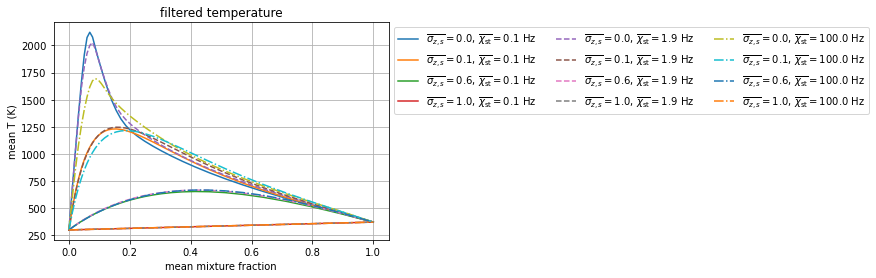

In [8]:
j = 0
chi = t_cg_prop_ad.dissipation_rate_stoich_mean_values[j]
for i in range(0, t_cg_prop_ad.scaled_scalar_variance_mean_npts, 3):
    svar = t_cg_prop_ad.scaled_scalar_variance_mean_values[i]
    plt.plot(t_cg_prop_ad.mixture_fraction_mean_values, np.squeeze(t_cg_prop_ad['temperature'][:, j, i]),
             '-',
             label='$\\overline{\sigma_{z,s}}=$'+f'{svar}'+', $\\overline{\\chi_{\\rm st}}=$'+f'{chi:.1f} Hz')
j = 3
chi = t_cg_prop_ad.dissipation_rate_stoich_mean_values[j]
for i in range(0, t_cg_prop_ad.scaled_scalar_variance_mean_npts, 3):
    svar = t_cg_prop_ad.scaled_scalar_variance_mean_values[i]
    plt.plot(t_cg_prop_ad.mixture_fraction_mean_values, np.squeeze(t_cg_prop_ad['temperature'][:, j, i]),
             '--',
             label='$\\overline{\sigma_{z,s}}=$'+f'{svar}'+', $\\overline{\\chi_{\\rm st}}=$'+f'{chi:.1f} Hz')
j = 7
chi = t_cg_prop_ad.dissipation_rate_stoich_mean_values[j]
for i in range(0, t_cg_prop_ad.scaled_scalar_variance_mean_npts, 3):
    svar = t_cg_prop_ad.scaled_scalar_variance_mean_values[i]
    plt.plot(t_cg_prop_ad.mixture_fraction_mean_values, np.squeeze(t_cg_prop_ad['temperature'][:, j, i]),
             '-.',
             label='$\\overline{\sigma_{z,s}}=$'+f'{svar}'+', $\\overline{\\chi_{\\rm st}}=$'+f'{chi:.1f} Hz')
plt.xlabel('mean mixture fraction')
plt.ylabel('mean T (K)')
plt.title('filtered temperature')
plt.grid()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=3)
plt.show()